## Linear regression model for car price forecasting

Importing all necessary modules

In [3604]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import itertools as it
import re

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PowerTransformer
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from scipy import stats

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import category_encoders as ce
from statsmodels.graphics.regressionplots import *

import eli5
from eli5.sklearn import PermutationImportance

import seaborn as sns
sns.set()

# Data cleanzing and transforming functions

In [3605]:
def outliers_remove(dataset,train):
    
#remove outliers based on interquantile range
        
    iqr=train['Price'].quantile(0.75)-train['Price'].quantile(0.25)
    dataset=dataset[dataset['Price']<=train['Price'].quantile(0.75)+iqr*1.5]
    dataset=dataset[dataset['Price']>=train['Price'].quantile(0.25)-iqr*1.5]
        
    return dataset


In [3606]:
def leverage_remove(dataset):
    
    y_train=dataset.Price
    X_train=dataset.drop('Price',axis=1)

    X_lev=X_train.select_dtypes(['float64','int64'])
    model_lev = sm.OLS(y_train, sm.add_constant(X_lev)).fit()

    influence = model_lev.get_influence()
    leverage = influence.hat_matrix_diag
    inf_sum = influence.summary_frame()

    price_res = pd.concat([y_train, inf_sum], axis = 1)
    price_res=price_res.rename(columns={'hat_diag': 'leverage'})

    l = price_res.leverage
    print ('High leverage:',price_res.Price[abs(l) > ((X_train.shape[1])+1)/X_train.shape[0]].count())
    leverage =price_res.Price[abs(l) > ((X_train.shape[1])+1)/X_train.shape[0]]

    leverage_index = leverage.index
    data_index = dataset.index

    data=dataset[data_index.isin(leverage_index)==False]


    return data

In [3607]:
def columns_numerical(X_train):
    return [cname for cname in X_train.columns if X_train[cname].dtype in ['int64', 'float64']]

In [3608]:
def columns_categorical(X_train):
    return [cname for cname in X_train.columns if X_train[cname].nunique() < 10 and 
                            X_train[cname].dtype == "object"and cname.find('target')<0 and cname.find('count')<0]

In [3609]:
def columns_target(X_train):
    return [cname for cname in X_train.columns if X_train[cname].dtype == "object" and cname.find('target')>0]

In [3610]:
def columns_count(X_train):
    return [cname for cname in X_train.columns if X_train[cname].dtype == "object" and cname.find('count')>0]

In [3611]:
def numerical_preprocessor(X_train):
    
    # Select numerical columns
    numerical_cols = columns_numerical(X_train)

    # Preprocessing for numerical data
    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())])
    
    X_transformed=X_train.copy()
    X_transformed[numerical_cols]=numerical_transformer.fit_transform(X_train[numerical_cols])
    
    return X_transformed

In [3612]:
def big_categorical_preprocessor (X_train, y_train):
    
    # Select categorical columns with relatively high cardinality 
    
    big_categorical_cols_count = columns_count(X_train)

    big_categorical_cols_target = columns_target(X_train)
    
    
    # Preprocessing
    big_categorical_transformer_target=ce.TargetEncoder(cols=big_categorical_cols_target)
    big_categorical_transformer_count=ce.CountEncoder(cols=big_categorical_cols_count)

    
    X_transformed=X_train.copy()
    X_transformed[big_categorical_cols_target]=big_categorical_transformer_target.fit_transform(X_train[big_categorical_cols_target], y_train)
    X_transformed[big_categorical_cols_count]=big_categorical_transformer_count.fit_transform(X_train[big_categorical_cols_count])

    return X_transformed

In [3613]:
def pipeline_preprocessing(X_train):
    
    # Select categorical columns with relatively low and high cardinality 
    
    categorical_cols = columns_categorical(X_train)

    big_categorical_cols_count = columns_count(X_train)

    big_categorical_cols_target = columns_target(X_train)
    
    # Select numerical columns
    numerical_cols = columns_numerical(X_train)

    # Preprocessing for numerical data
    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())])



    # Preprocessing for categorical data
    categorical_transformer = OneHotEncoder(sparse=False, drop='first')

    big_categorical_transformer_target=ce.TargetEncoder()
    big_categorical_transformer_count=ce.CountEncoder()


    # Bundle preprocessing for numerical and categorical data
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_cols),
            ('cat', categorical_transformer, categorical_cols),
            ('big_cat_count',big_categorical_transformer_count, big_categorical_cols_count),
            ('big_cat_target',big_categorical_transformer_target, big_categorical_cols_target)])
    
    return preprocessor

# Features functions

In [3614]:
def multicolinearity_check(X):
    variables=X.select_dtypes(['float64','int64'])
    vif = pd.DataFrame()
    vif["VIF"] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
    vif["features"] = variables.columns
    return vif

In [3615]:
def create_interactions(dataset):
    cat_features = dataset.select_dtypes('object').columns
    name=""
    for encode in ['target','count']:
        for item in it.combinations(cat_features, 2):
            name=item[0]+"_"+item[1]+"_"+encode
            dataset[name]=dataset[item[0]].astype('str')+"_"+dataset[item[1]].astype('str')
    
    for cols in cat_features:
        name=cols+"_"+'target'
        dataset[name]=dataset[cols]
        name=cols+"_"+'count'
        dataset[name]=dataset[cols]
    
    return dataset

In [3616]:
def features_importance(X_train, y_train):
    
    model=LinearRegression()
    X_tocheck=X_train.select_dtypes(['float64','int64'])

    model.fit(X_tocheck, y_train)
    perm = PermutationImportance(model, random_state=0).fit(X_tocheck, y_train)
    return eli5.show_weights(perm, feature_names = X_tocheck.columns.tolist())
    

# Modeling fucntions

Fit OLS model from statsmodel to check regression summary

In [3617]:
def OLS_with_summary(X_train, y_train):
    
    X_train_OLS = pd.get_dummies(X_train, drop_first=True)
    
    
    X = sm.add_constant(X_train_OLS)
    model_OLS = sm.OLS(y_train,X)
    results = model_OLS.fit()
    #return linear regression summary
    return results.summary()

Fit sklearn pipeline with linear regression

In [3618]:
def pipeline_fit(X_train,y_train):
                            
    preprocessor=pipeline_preprocessing(X_train)
    model=LinearRegression()
    
    
    # Bundle preprocessing and modeling code in a pipeline
    my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)])

    # Preprocessing of training data, fit model 
    my_pipeline=my_pipeline.fit(X_train, y_train)
    print('R2: {}, Intercept: {}'.format(my_pipeline.score(X_train, y_train).round(decimals=3), my_pipeline.named_steps['model'].intercept_.round(decimals=3)))
    return my_pipeline

In [3619]:
def predictions(X_train, y_train, X_test, y_test):
    
    pipeline=pipeline_fit(X_train,y_train)

    # Preprocessing of validation data, get predictions
    preds = pipeline.predict(X_test)    
    

    #Create data frame with predictions and residuals
    predictions=pd.DataFrame(np.exp(preds), columns=['Prediction'])
    y_test = y_test.reset_index(drop=False)
   
    
    predictions['Car_index']=y_test['index']
    predictions['Target']=np.exp(y_test['Price'])
    predictions['Residuals']=predictions['Target']-predictions['Prediction']
    predictions['Difference%'] = np.absolute(predictions['Residuals']/predictions['Target']*100)
    
    # Evaluate the model
    score = mean_absolute_error(predictions['Target'], predictions['Prediction'])
    MAPE=np.abs(predictions['Residuals']).sum()/predictions['Target'].sum()*100
    
    print('MAE:', score.round(decimals=3))
    print('MAPE:', MAPE.round(decimals=3))
    
    return predictions


In [3620]:
data = pd.read_csv('1.04. Real-life example.csv')
data.head()

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,Model
0,BMW,4200.0,sedan,277,2.0,Petrol,yes,1991,320
1,Mercedes-Benz,7900.0,van,427,2.9,Diesel,yes,1999,Sprinter 212
2,Mercedes-Benz,13300.0,sedan,358,5.0,Gas,yes,2003,S 500
3,Audi,23000.0,crossover,240,4.2,Petrol,yes,2007,Q7
4,Toyota,18300.0,crossover,120,2.0,Petrol,yes,2011,Rav 4


In [3621]:
data.describe(include='all')

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,Model
count,4345,4173.000000,4345,4345.000000,4195.000000,4345,4345,4345.000000,4345
unique,7,NaN,6,NaN,NaN,4,2,NaN,312
top,Volkswagen,NaN,sedan,NaN,NaN,Diesel,yes,NaN,E-Class
freq,936,NaN,1649,NaN,NaN,2019,3947,NaN,199
mean,NaN,19418.746935,NaN,161.237284,2.790734,NaN,NaN,2006.550058,NaN
std,NaN,25584.242620,NaN,105.705797,5.066437,NaN,NaN,6.719097,NaN
min,NaN,600.000000,NaN,0.000000,0.600000,NaN,NaN,1969.000000,NaN
25%,NaN,6999.000000,NaN,86.000000,1.800000,NaN,NaN,2003.000000,NaN
50%,NaN,11500.000000,NaN,155.000000,2.200000,NaN,NaN,2008.000000,NaN
75%,NaN,21700.000000,NaN,230.000000,3.000000,NaN,NaN,2012.000000,NaN


In [3622]:
data.dropna(subset=['Price','EngineV'],axis=0,inplace=True)
data=data[data['EngineV']<6.5]

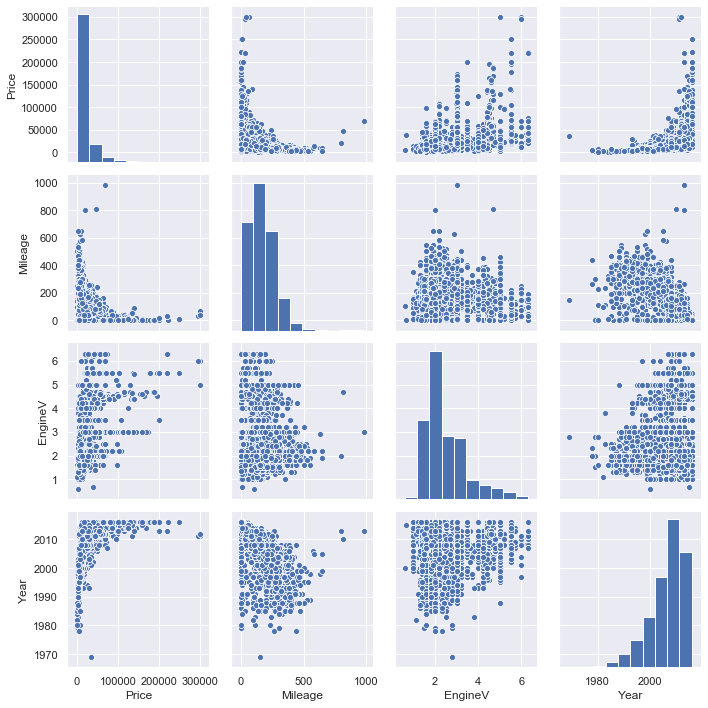

In [3623]:
sns.pairplot(data.select_dtypes(['float64','int64']), height=2.5)
plt.tight_layout()

In [3624]:
# data['Price']= np.log(data['Price'])
data['Registration']=data['Registration'].replace({'yes':True,'no':False})


In [3625]:
y=data.Price
X=data.drop(['Price'], axis=1)

In [3626]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [3627]:
data_train=data[data.index.isin(X_train.index)]
data_test=data[data.index.isin(X_test.index)]
data_test.describe()

,Price,Mileage,EngineV,Year
count,801.000000,801.000000,801.000000,801.000000
mean,20242.420699,158.620474,2.474707,2006.855181
std,26131.437370,101.399498,0.973067,6.591017
min,999.000000,0.000000,1.000000,1980.000000
25%,7300.000000,85.000000,1.800000,2003.000000
50%,11960.000000,150.000000,2.200000,2008.000000
75%,22900.000000,219.000000,3.000000,2012.000000
max,300000.000000,650.000000,6.300000,2016.000000


In [3628]:
data_clean=outliers_remove(data_train,data_train)
data_clean=leverage_remove(data_clean)
print(data_clean.describe())

data_clean['Price']= np.log(data_clean['Price'])

y_train=data_clean.Price
X_train=data_clean.drop(['Price'], axis=1)


G:\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


High leverage: 218
              Price      Mileage      EngineV         Year
count   2693.000000  2693.000000  2693.000000  2693.000000
mean   13103.627805   174.204233     2.269213  2006.189751
std     8956.152855    90.186874     0.714585     5.735698
min      800.000000     0.000000     0.600000  1988.000000
25%     6900.000000   110.000000     1.800000  2003.000000
50%    10500.000000   170.000000     2.000000  2007.000000
75%    17500.000000   238.000000     2.500000  2011.000000
max    43163.250000   450.000000     4.800000  2016.000000


In [3629]:
data_clean_test=outliers_remove(data_test, data_train)
data_clean_test=leverage_remove(data_clean_test)

print(data_clean_test.describe())

data_clean_test['Price']= np.log(data_clean_test['Price'])

y_test=data_clean_test.Price
X_test=data_clean_test.drop(['Price'], axis=1)



High leverage: 58
              Price     Mileage     EngineV         Year
count    664.000000  664.000000  664.000000   664.000000
mean   14034.421506  168.715361    2.307139  2006.873494
std     9649.813587   88.706230    0.778735     5.426233
min     1389.000000    0.000000    1.000000  1989.000000
25%     7300.000000  109.750000    1.800000  2003.000000
50%    10900.000000  161.500000    2.000000  2008.000000
75%    18325.000000  220.000000    2.725000  2011.000000
max    43000.000000  435.000000    5.000000  2016.000000


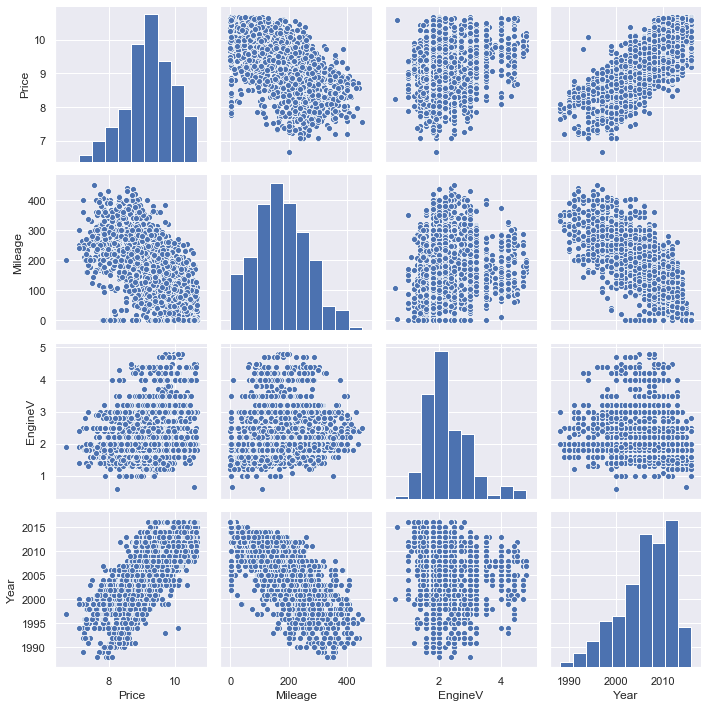

In [3630]:
sns.pairplot(data_clean.select_dtypes(['float64','int64']), height=2.5)
plt.tight_layout()

In [3631]:
VIF=multicolinearity_check(X_train)
VIF

,VIF,features
0,4.824646,Mileage
1,11.363939,EngineV
2,13.066533,Year


In [3632]:
data_clean['Year']=data_clean['Year'].astype('str')
data_clean_test['Year']=data_clean_test['Year'].astype('str')

X_train=data_clean.drop(['Price'], axis=1)
X_test=data_clean_test.drop(['Price'], axis=1)

VIF_without_Year=multicolinearity_check(X_train)
VIF_without_Year

,VIF,features
0,4.081872,Mileage
1,4.081872,EngineV


In [3633]:
data_interactions=create_interactions(data_clean)
X_train=data_interactions.drop(['Price'], axis=1)


In [3634]:
data_interactions_test=create_interactions(data_clean_test)
X_test=data_interactions_test.drop(['Price'], axis=1)


In [3635]:
X_train_transformed=numerical_preprocessor(X_train)
X_train_transformed=big_categorical_preprocessor(X_train_transformed,y_train)
X_train_transformed.head()

,Brand,Body,Mileage,EngineV,Engine Type,Registration,Year,Model,Brand_Body_target,Brand_Engine Type_target,...,Brand_target,Brand_count,Body_target,Body_count,Engine Type_target,Engine Type_count,Year_target,Year_count,Model_target,Model_count
0,BMW,sedan,1.140020,-0.376810,Petrol,True,1991,320,9.061218,9.369043,...,9.287250,387,9.160019,1025,9.303247,951,8.219838,20,8.857860,46
3,Audi,crossover,0.729685,2.702472,Petrol,True,2007,Q7,10.115637,9.558212,...,9.163050,294,9.889243,446,9.303247,951,9.427802,242,10.144904,26
6,BMW,sedan,2.925534,-0.376810,Gas,True,1997,320,9.061218,9.048359,...,9.287250,387,9.160019,1025,9.235229,433,8.426220,52,8.857860,46
7,Audi,vagon,0.286079,0.602962,Diesel,True,2006,A6,8.720803,8.942052,...,9.163050,294,8.910467,300,9.210336,1242,9.233299,156,8.898544,126
8,Renault,vagon,0.208448,-1.076647,Diesel,True,2012,Megane,8.948843,8.942323,...,8.904019,340,8.910467,300,9.210336,1242,9.624425,236,9.054646,64


In [3636]:
features_importance(X_train_transformed, y_train)

Weight,Feature
0.1528 ± 0.0051,Model_count
0.1448 ± 0.0100,Model_target
0.1433 ± 0.0113,Brand_Year_target
0.1167 ± 0.0092,Brand_Model_target
0.1143 ± 0.0030,Body_Year_target
0.0941 ± 0.0035,Engine Type_Year_target
0.0820 ± 0.0070,Brand_Model_count
0.0637 ± 0.0054,Year_Model_target
0.0581 ± 0.0094,EngineV
0.0296 ± 0.0056,Body_target


In [3637]:
VIF_with_interactions=multicolinearity_check(X_train_transformed)
VIF_with_interactions

,VIF,features
0,2.561055e+00,Mileage
1,2.006691e+00,EngineV
2,6.591000e+03,Brand_Body_target
3,4.493667e+03,Brand_Engine Type_target
4,2.181298e+03,Brand_Year_target
5,2.787654e+06,Brand_Model_target
6,1.704851e+04,Body_Engine Type_target
7,4.752035e+03,Body_Year_target
8,3.832850e+03,Body_Model_target
9,7.295180e+03,Engine Type_Year_target


In [3638]:
X_train_final=X_train_transformed[columns_numerical(X_train)+columns_count(X_train)+['Model_target']]
VIF_final=multicolinearity_check(X_train_final)
VIF_final

,VIF,features
0,1.273133,Mileage
1,1.250532,EngineV
2,12.065084,Brand_Body_count
3,16.527922,Brand_Engine Type_count
4,11.000607,Brand_Year_count
5,2954.244917,Brand_Model_count
6,9.854565,Body_Engine Type_count
7,17.544915,Body_Year_count
8,9.306863,Body_Model_count
9,26.698051,Engine Type_Year_count


In [3639]:
features_importance(X_train_final, y_train)

G:\Anaconda\lib\site-packages\IPython\core\displayhook.py:276: UserWarning: Output cache limit (currently 1000 entries) hit.
Flushing oldest 200 entries.
  'Flushing oldest {cull_count} entries.'.format(sz=sz, cull_count=cull_count))


Weight,Feature
0.4152 ± 0.0277,Model_target
0.3959 ± 0.0181,Model_count
0.3213 ± 0.0113,Mileage
0.2328 ± 0.0183,Brand_Model_count
0.0897 ± 0.0135,Year_count
0.0677 ± 0.0051,Engine Type_Year_count
0.0586 ± 0.0076,Brand_Year_count
0.0499 ± 0.0068,EngineV
0.0212 ± 0.0045,Body_Year_count
0.0129 ± 0.0013,Brand_Body_count


In [3640]:
X_train_final=X_train_transformed[columns_numerical(X_train)+['Model_target']]
VIF_final=multicolinearity_check(X_train_final)
VIF_final

,VIF,features
0,1.026219,Mileage
1,1.026376,EngineV
2,1.001114,Model_target


In [3641]:
features_importance(X_train_final, y_train)

Weight,Feature
0.4518 ± 0.0288,Model_target
0.3401 ± 0.0077,Mileage
0.0464 ± 0.0106,EngineV


In [3642]:
X_train_final=X_train_final.join(X_train[columns_categorical])
X_train_final=X_train_final.join(X_train['Registration'])
X_train_final.head()

,Mileage,EngineV,Model_target,Brand,Body,Engine Type,Registration
0,1.140020,-0.376810,8.857860,BMW,sedan,Petrol,True
3,0.729685,2.702472,10.144904,Audi,crossover,Petrol,True
6,2.925534,-0.376810,8.857860,BMW,sedan,Gas,True
7,0.286079,0.602962,8.898544,Audi,vagon,Diesel,True
8,0.208448,-1.076647,9.054646,Renault,vagon,Diesel,True


In [3643]:
X_train_final=X_train[X_train_final.columns]
X_test_final=X_test[X_train_final.columns]

In [3644]:
X_train_final['Registration']=X_train_final['Registration'].astype('str')

X_train_transformed_final=numerical_preprocessor(X_train_final)
X_train_transformed_final=big_categorical_preprocessor(X_train_transformed_final,y_train)


OLS_with_summary(X_train_transformed_final, y_train)

G:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
G:\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.777
Model:                            OLS   Adj. R-squared:                  0.775
Method:                 Least Squares   F-statistic:                     517.3
Date:                Sun, 16 Feb 2020   Prob (F-statistic):               0.00
Time:                        23:54:16   Log-Likelihood:                -911.99
No. Observations:                2693   AIC:                             1862.
Df Residuals:                    2674   BIC:                             1974.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   4.1234      0.193     21.348      0.000       3.745       4.502
Mileage                -0.3084      0.008    -36.776      0.000      -0.325      -0.292
EngineV                 0.0890      0.009      9.634      0.000       0.071       0.107
Model_target            0.5014      0.020     25.082      0.000       0.462       0.541
Brand_BMW               0.0063      0.027      0.235      0.814      -0.046       0.059
Brand_Mercedes-Benz    -0.0696      0.027     -2.596      0.009      -0.122      -0.017
Brand_Mitsubishi       -0.3402      0.032    -10.481      0.000      -0.404      -0.277
Brand_Renault          -0.4186      0.031    -13.488      0.000      -0.479      -0.358
Brand_Toyota           -0.2219      0.029     -7.607      0.000      -0.279      -0.165
Brand_Volkswagen       -0.1829      0.026     -7.016      0.000      -0.234      -0.132
Body_hatch             -0.2089      0.036     -5.742      0.000      -0.280      -0.138
Body_other             -0.0810      0.030     -2.703      0.007      -0.140      -0.022
Body_sedan             -0.0753      0.025     -3.012      0.003      -0.124      -0.026
Body_vagon             -0.0997      0.032     -3.133      0.002      -0.162      -0.037
Body_van               -0.1601      0.030     -5.286      0.000      -0.220      -0.101
Engine Type_Gas        -0.2292      0.022    -10.465      0.000      -0.272      -0.186
Engine Type_Other      -0.1129      0.043     -2.610      0.009      -0.198      -0.028
Engine Type_Petrol     -0.2279      0.018    -12.602      0.000      -0.263      -0.192
Registration_True       0.9636      0.024     40.629      0.000       0.917       1.010
==============================================================================
Omnibus:                      348.895   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1175.042
Skew:                          -0.639   Prob(JB):                    6.96e-256
Kurtosis:                       5.973   Cond. No.                         281.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [3645]:
X_test_final['Registration']=X_test_final['Registration'].astype('str')

G:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [3646]:
X_test_final.head()

,Mileage,EngineV,Model_target,Brand,Body,Engine Type,Registration
1,427,2.9,Sprinter 212,Mercedes-Benz,van,Diesel,True
4,120,2.0,Rav 4,Toyota,crossover,Petrol,True
10,177,1.5,Megane,Renault,vagon,Diesel,True
14,250,4.7,Land Cruiser 100,Toyota,crossover,Gas,True
15,84,1.5,Clio,Renault,hatch,Diesel,True


In [3647]:
results=predictions(X_train_final,y_train, X_test_final, y_test)

R2: 0.777, Intercept: 4.123
MAE: 3359.232
MAPE: 23.936


In [3648]:
data_test[data_test.Model=='Pajero Wagon']

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,Model
32,Mitsubishi,17900.0,crossover,87,3.8,Gas,True,2008,Pajero Wagon
505,Mitsubishi,26850.0,crossover,84,3.2,Diesel,True,2012,Pajero Wagon
943,Mitsubishi,14500.0,crossover,167,3.0,Gas,True,2008,Pajero Wagon
1023,Mitsubishi,20500.0,crossover,109,3.2,Diesel,True,2009,Pajero Wagon
1127,Mitsubishi,8400.0,crossover,100,3.2,Diesel,True,2011,Pajero Wagon
2037,Mitsubishi,15900.0,crossover,180,3.0,Gas,True,2008,Pajero Wagon
2208,Mitsubishi,11999.0,crossover,235,3.0,Gas,True,2007,Pajero Wagon
2876,Mitsubishi,14500.0,crossover,90,3.0,Petrol,True,2008,Pajero Wagon
3594,Mitsubishi,17000.0,crossover,215,3.8,Petrol,True,2006,Pajero Wagon
3862,Mitsubishi,10500.0,crossover,95,3.2,Diesel,False,2008,Pajero Wagon


In [3649]:
data[data.index==1127]

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,Model
1127,Mitsubishi,8400.0,crossover,100,3.2,Diesel,True,2011,Pajero Wagon


In [3650]:
print(results.sort_values(by=['Difference%']).tail(10))
results.describe()

       Prediction  Car_index  Target     Residuals  Difference%
195  22031.196432       1127  8400.0 -13631.196432   162.276148
161   6035.802231        957  2250.0  -3785.802231   168.257877
481  13972.079978       3128  4999.0  -8973.079978   179.497499
605   9588.478260       4023  3350.0  -6238.478260   186.223232
417  14563.289122       2594  4800.0  -9763.289122   203.401857
225   9847.296909       1325  3000.0  -6847.296909   228.243230
355  11960.645992       2224  3600.0  -8360.645992   232.240166
604   9981.493846       4006  2600.0  -7381.493846   283.903609
425  18061.911336       2681  4000.0 -14061.911336   351.547783
561  25762.896052       3592  5500.0 -20262.896052   368.416292


,Prediction,Car_index,Target,Residuals,Difference%
count,664.000000,664.000000,664.000000,664.000000,664.000000
mean,12887.113204,2090.442771,14034.421506,1147.308302,26.113092
std,7751.889940,1287.259587,9649.813587,5200.618936,34.206615
min,1417.464485,1.000000,1389.000000,-20262.896052,0.058950
25%,7471.283162,970.750000,7300.000000,-1489.078065,8.929634
50%,11505.464599,2054.000000,10900.000000,121.312370,18.011082
75%,16292.505863,3233.500000,18325.000000,2289.857869,31.853475
max,49088.035847,4344.000000,43000.000000,26169.812615,368.416292


Text(0, 0.5, 'Residuals')

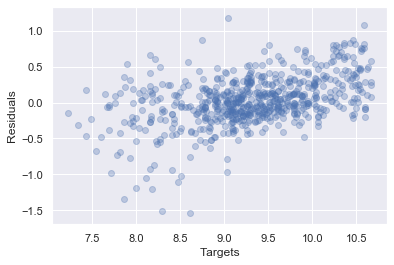

In [3651]:
plt.scatter(np.log(results['Target']),np.log(results['Target'])-np.log(results['Prediction']),alpha=0.3)
# plt.scatter(results['Target'],results['Residuals'],alpha=0.3)
plt.xlabel('Targets',size=12)
plt.xlabel('Targets',size=12)
plt.ylabel('Residuals',size=12)

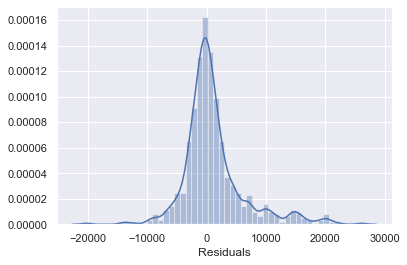

In [3652]:
sns.distplot(results['Residuals'])

(0, 50000)

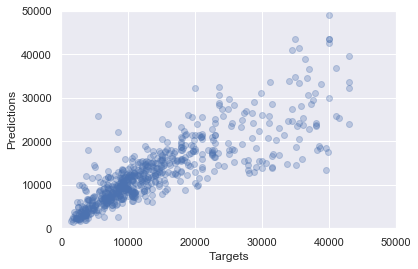

In [3653]:

plt.scatter(results['Target'],results['Prediction'],alpha=0.3)
plt.xlabel('Targets',size=12)
plt.ylabel('Predictions',size=12)
plt.xlim(0,50000)
plt.ylim(0,50000)


In [3654]:
# scores=cross_val_score(my_pipeline, X, y, cv=5)
# print('Accuracy:',scores.mean().round(decimals=3))